In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from IPython.display import clear_output
import warnings
import os 
from glob import glob 
import pandas as pd 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#디렉토리 생성 

In [2]:
!mkdir -p ./thumb/train/up
!mkdir -p ./thumb/train/down
!mkdir -p ./thumb/test/up
!mkdir -p ./thumb/test/down

# 이미지 캡쳐 

In [3]:
def take_photo(last_file_path, quality=1.0):

    js = Javascript('''

        async function takePhoto([last_file_path, quality]) {

            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            video.height = 224
            video.width = 224
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            // google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);


            const capture = document.createElement('button');
            const train_up = document.createElement('button')
            const train_down = document.createElement('button');
            const test_up = document.createElement('button');
            const test_down = document.createElement('button');

            capture.textContent = 'Capture';
            train_up.textContent = 'Train/up';
            train_down.textContent = 'Train/Down';
            test_up.textContent = 'Test/Up';
            test_down.textContent = 'Test/Down';

            div.appendChild(capture);
            div.appendChild(train_up);
            div.appendChild(train_down);
            div.appendChild(test_up);
            div.appendChild(test_down);
            
            file_path = last_file_path
            train_up.onclick   = function(){ file_path = './thumb/train/up' }
            train_down.onclick = function(){ file_path = './thumb/train/down' }
            test_up.onclick    = function(){ file_path = './thumb/test/up' }
            test_down.onclick  = function(){ file_path = './thumb/test/down' }

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            // canvas.width = video.videoWidth;
            // canvas.height = video.videoHeight;
            canvas.width = 224;
            canvas.height = 224;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            
            return [canvas.toDataURL('image/jpeg', quality), file_path];
        }
        
    ''')

    display(js)

    data, file_path = eval_js('takePhoto({})'.format([last_file_path, quality]))
    binary = b64decode(data.split(',')[1])
    return binary, file_path


In [4]:
def find_max_index(file_path):
    import re
    file_names = glob(file_path)
    # file_names = ['Picture 03.jpg', '02.jpg', '1.jpg']
    if len(file_names)==0: return 0

    file_indexes = [int(re.sub('\D','',file_name)) for file_name in file_names]
    # file_indexes = [3, 2, 1]

    max_value = max(file_indexes)
    # max_value = 3
    return max_value

max_index = find_max_index('./thumb/train/up/*')
print(max_index)

0


In [5]:
last_file_path = "./thumb/train/up"
while(True):
  binary, file_path = take_photo(last_file_path)
  max_index += 1
  file_name = f'{file_path}/image{max_index}.jpg'
  
  with open(file_name,'wb') as f:
    f.write(binary)
#   print(file_name)
  last_file_path = file_path


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

# 모델 학습

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 256)               17662208  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 25,432,315
Trainable params: 17,663,234
Non

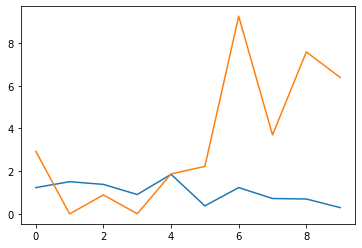

1/1 [==============================] - 0s 70ms/step - loss: 6.3889 - acc: 0.4286
loss= 6.388857364654541
acc= 0.4285714328289032


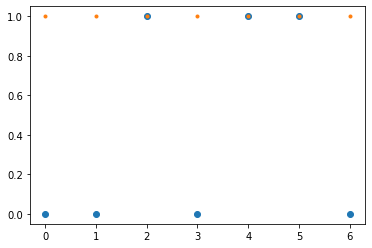

label category index = 0.0
predicted category index = 1
predicted category name = up


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "thumb/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "thumb/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# tensorflow js 설치

In [7]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 40 kB 7.1 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# 모델 저장

In [8]:
model.save("thumb.h5")

In [9]:
import tensorflowjs as tfjs

In [12]:
tfjs.converters.save_keras_model(model, "thumb_model")

weight normalization/count with shape () and dtype int64 was auto converted to the type int32


In [21]:
!tar cvfz thumb_model.tar.gz thumb_model

thumb_model/
thumb_model/group1-shard6of25.bin
thumb_model/group1-shard4of25.bin
thumb_model/group1-shard14of25.bin
thumb_model/group1-shard1of25.bin
thumb_model/group1-shard25of25.bin
thumb_model/model.json
thumb_model/group1-shard8of25.bin
thumb_model/group1-shard11of25.bin
thumb_model/group1-shard5of25.bin
thumb_model/group1-shard7of25.bin
thumb_model/group1-shard3of25.bin
thumb_model/group1-shard16of25.bin
thumb_model/group1-shard18of25.bin
thumb_model/group1-shard20of25.bin
thumb_model/group1-shard19of25.bin
thumb_model/group1-shard10of25.bin
thumb_model/group1-shard2of25.bin
thumb_model/group1-shard23of25.bin
thumb_model/group1-shard12of25.bin
thumb_model/group1-shard9of25.bin
thumb_model/group1-shard22of25.bin
thumb_model/group1-shard21of25.bin
thumb_model/group1-shard15of25.bin
thumb_model/group1-shard13of25.bin
thumb_model/group1-shard17of25.bin
thumb_model/group1-shard24of25.bin


In [24]:
!ls -alh

total 345M
drwxr-xr-x 1 root root 4.0K Jul 21 07:32 .
drwxr-xr-x 1 root root 4.0K Jul 21 07:32 ..
drwxr-xr-x 4 root root 4.0K Jul 13 13:42 .config
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data
drwxr-xr-x 4 root root 4.0K Jul 21 07:27 thumb
-rw-r--r-- 1 root root 165M Jul 21 07:29 thumb.h5
drwxr-xr-x 2 root root 4.0K Jul 21 07:30 thumb_model
-rw-r--r-- 1 root root  90M Jul 21 07:30 thumb_model.tar
-rw-r--r-- 1 root root  90M Jul 21 07:32 thumb_model.tar.gz


# G Drive에 모델 파일 카피

In [18]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [19]:
!cp thumb.h5 /gdrive/MyDrive/tmp/

In [25]:
!cp thumb_model.tar.gz /gdrive/MyDrive/tmp/